In [76]:
from pathlib import Path
from dataclasses import asdict
from solarmed_optimization.utils.serialization import OptimizationResults
from solarmed_optimization.utils.initialization import (problem_initialization,
                                                        initialize_problem_instance)
# auto reload modules
%load_ext autoreload
%autoreload 2

# Constants
output_path: Path = Path("../results/") / "b/20180921_20180928_eval_at_20250113/nsga2"
data_path: Path = Path("../data")
fsm_data_path: Path = Path("../results/fsm_data")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
optim_results = OptimizationResults.load(output_path = output_path)
print(f"Loaded {output_path} results.\nAvailable fields: {[key for key in asdict(optim_results)]}")

metadata = optim_results.metadata

problem_data = problem_initialization(problem_params=optim_results.problem_params,
                                      date_str=metadata["date_str"],
                                      data_path=data_path,
                                      initial_states=optim_results.initial_states)

problem = initialize_problem_instance(problem_data=problem_data, idx_mod=problem_data.problem_params.idx_start,
                                      fsm_data_path=fsm_data_path)



Loaded ../results/b/20180921_20180928_eval_at_20250113/nsga2 results.
Available fields: ['metadata', 'problem_params', 'initial_states', 'algo_log', 'df_hor', 'df_sim', 'pop_results', 'algo_params', 'figs']


2025-01-13 15:20:28.020 | WARNING  | solarmed_optimization.utils.initialization:problem_initialization:103 - External environment data (20220524 - 20240524) (seawater temperature and salinity) is not available for the data period (20180921 - 20180928). Using data for same month and days but from closest year 2022.


In [78]:
from solarmed_optimization.visualization.optim_evolution import plot_obj_space_1d

fig = plot_obj_space_1d(fitness_history=optim_results.pop_results[0].fitness_per_gen, animation=False)
fig.update_layout(title=f"{metadata['date_str']} - Fitness evolution - {metadata['algo_id'].upper()}",
                           margin=dict(t=50, b=100), height=600)

fig


In [69]:
from solarmed_optimization.visualization.optim_evolution import plot_dec_vars_evolution

plot_dec_vars_evolution(problem=problem, df_hors_=optim_results.df_hor, df_mod=optim_results.df_sim, 
                        full_xaxis_range=False, episode_samples=problem_data.problem_samples.episode_samples)


AttributeError: 'bool' object has no attribute 'dtype'

In [34]:
optim_results.df_hor


[    penalty    Jsf_ts  current_sample  wmed_f       Tamb           I  \
 2       0.0  0.000000               1      35  22.872050    0.000000   
 3       0.0  0.000000               2      35  22.943050    0.000000   
 4       0.0  0.000000               3      35  22.986950    0.000000   
 5       0.0  0.000000               4      35  22.689775    0.000000   
 6       0.0  0.000000               5      35  22.586250    0.000000   
 ..      ...       ...             ...     ...        ...         ...   
 69      0.0  0.438726              68      35  32.886975  973.171267   
 70      0.0  0.438726              69      35  33.055250  975.195170   
 71      0.0  0.438726              70      35  33.109000  973.901860   
 72      0.0  0.438726              71      35  33.142050  974.726022   
 73      0.0  0.438726              72      35  33.145125  975.475992   
 
     Tmed_c_in  qts_src_sp   qts_src    qts_dis  ...  upper_bounds_Tmed_s_in  \
 2   21.859964    0.000000  0.000000   0.0

<Axes: >

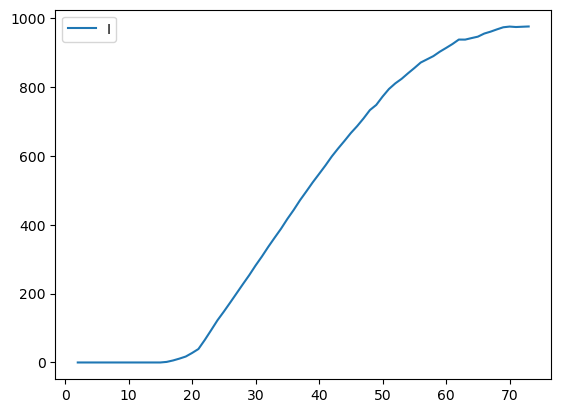

In [48]:
optim_results.df_hor[0][["I"]].plot()


<Axes: >

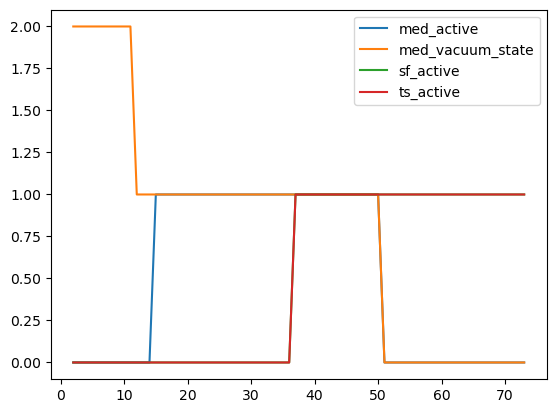

In [60]:
optim_results.df_hor[0][["med_active", "med_vacuum_state", "sf_active", "ts_active"]].astype(int).plot()


<Axes: >

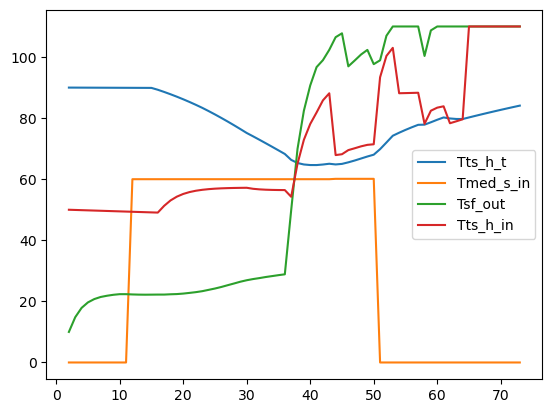

In [61]:
optim_results.df_hor[0][["Tts_h_t", "Tmed_s_in", "Tsf_out", "Tts_h_in"]].plot()


In [54]:
optim_results.df_hor[0].columns


Index(['penalty', 'Jsf_ts', 'current_sample', 'wmed_f', 'Tamb', 'I',
       'Tmed_c_in', 'qts_src_sp', 'qts_src', 'qts_dis', 'Tts_h_in', 'Tts_c_in',
       'Tts_h_out', 'Pth_ts_src', 'Pth_ts_dis', 'Jts', 'qsf_sp', 'qsf',
       'Tsf_out', 'Tsf_in', 'SEC_sf', 'Jsf', 'Pth_sf', 'qmed_s_sp',
       'qmed_f_sp', 'Tmed_s_in_sp', 'Tmed_c_out_sp', 'qmed_s', 'qmed_f',
       'Tmed_s_in', 'Tmed_c_out', 'qmed_c', 'Tmed_s_out', 'qmed_d', 'qmed_b',
       'Jmed', 'Pth_med', 'STEC_med', 'SEEC_med', 'Thx_p_in', 'Thx_p_out',
       'Thx_s_in', 'Thx_s_out', 'qhx_p', 'qhx_s', 'Pth_hx_p', 'Pth_hx_s',
       'epsilon_hx', 'R3wv', 'q3wv_src', 'q3wv_dis', 'T3wv_src', 'T3wv_dis_in',
       'T3wv_dis_out', 'med_active', 'sf_active', 'ts_active', 'Jtotal',
       'total_cost', 'total_income', 'net_profit', 'net_loss',
       'med_vacuum_state', 'med_state', 'sf_state', 'ts_state', 'sf_ts_state',
       'current_state', 'Tts_h_t', 'Tts_h_m', 'Tts_h_b', 'Tts_c_t', 'Tts_c_m',
       'Tts_c_b', 'upper_bounds_qsf',

# Old

In [11]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from loguru import logger
import pygmo as pg

from solarmed_optimization import (EnvironmentVariables,
                                   ProblemParameters,
                                   ProblemSamples,)
from solarmed_optimization.problems.pygmo import MinlpProblem
from solarmed_optimization.utils.initialization import problem_initialization
from solarmed_optimization.utils.evaluation import evaluate_optimization

# auto reload modules
%load_ext autoreload
%autoreload 2

logger.disable("phd_visualizations")

#%% Constants
# Paths definition
output_path: Path = Path("../results")
data_path: Path = Path("../data")
fsm_data_path: Path = Path("../results")
date_str: str = "20230703" # "20230707_20230710" # '20230630' '20230703'
pop_size: int = 32
n_gen: int = 80
# n_islands: int = 10
seed_num: int = 23

# Get or set problem data (parameters, samples, experimental data and model instance)
# Either load parameters from json or create a new instance
# with open(output_path / "problem_params.json") as f:
#     problem_params = ProblemParameters(**json.load(f))
problem_params = ProblemParameters(
    optim_window_time=8*3600, # 8 hours
)
problem_data = problem_initialization(problem_params=problem_params,
                                      date_str=date_str,
                                      data_path=data_path)
ps: ProblemSamples = problem_data.problem_samples
pp: ProblemParameters = problem_data.problem_params
df: pd.DataFrame = problem_data.df
model = problem_data.model

df_hors: list[list[pd.DataFrame]] = []
df_sim: pd.DataFrame = None
pop_history: list[pg.population] = []

# Setup optimization algorithm / computation strategy
# algorithm = pg.gaco(gen=n_gen, ker=pop_size, seed=seed_num)
# algo = pg.algorithm(algorithm)
# algo.set_verbosity(1) # regulates both screen and log verbosity
# island = pg.ipyparallel_island()

opt_step_idx: int = 0
# for opt_step_idx in range(0, max_opt_steps):
idx_mod = pp.idx_start
max_opt_steps: int = (len(df)-pp.idx_start-ps.optim_window_samples) // ps.n_evals_mod_in_opt_step - 1

for opt_step_idx in range(0, max_opt_steps):
    hor_span = (idx_mod+1, idx_mod+1+ps.n_evals_mod_in_hor_window)


    # Optimization step `opt_step_idx`
    # 1. Initialize a problem instance for the current step and solve it
    ## Intialize model instance
    ds = df.iloc[idx_mod]

    ## Environment variables predictions
    ds = df.iloc[hor_span[0]:hor_span[1]]
    env_vars: EnvironmentVariables = EnvironmentVariables(
        I=ds['I'].values,
        Tamb=ds['Tamb'].values,
        Tmed_c_in=ds['Tmed_c_in'].values,
        cost_w=np.ones((ps.n_evals_mod_in_hor_window, )) * pp.env_params.cost_w,
        cost_e=np.ones((ps.n_evals_mod_in_hor_window, )) * pp.env_params.cost_e,
    )

    ## Create problem instance
    problem = MinlpProblem(
        model=model, 
        sample_time_opt=pp.sample_time_opt,
        optim_window_time=pp.optim_window_time,
        env_vars=env_vars,
        dec_var_updates=pp.dec_var_updates,
        fsm_valid_sequences=pp.fsm_valid_sequences,
        fsm_data_path=fsm_data_path
    )

    ## Find optimal decision variables
    # isl = pg.island(algo = algo,  prob = prob, size=pop_size) # udi=island
    # isl.evolve()
    # print(isl)
    # isl.wait()
    # Export results

    eval_id: str = f"data_20230703_algo_sga_step_{opt_step_idx:02d}_eval_at_20250104"
    results_files: list[str] = [f"algo_df_{eval_id}.csv", f"pop_dict_{eval_id}.json"]
    algo_log: pd.DataFrame = pd.read_csv(output_path / results_files[0])
    pop_dict: dict = json.load(open(output_path / results_files[1]))
    pop_dict["x"] = [np.array(x) for x in pop_dict["x"]]

    df_hor, df_sim, model = evaluate_optimization(df_sim=df_sim, pop=pop_dict["x"][-1], 
                                        best_idx=pop_dict["best_idx"][-1],
                                        env_vars=env_vars, problem=problem,
                                        problem_data=problem_data, idx_mod=idx_mod)
    df_hors.append(df_hor)

    # Finally, increase counter
    idx_mod += ps.n_evals_mod_in_opt_step


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
print(f"{len(df_hors)=}")
print(f"{len(df_hors[0])=}")

df_hors[0] = df_hors[0][0] # Make it so that the past populations only contain the best 


len(df_hors)=2
len(df_hors[0])=32


In [15]:
print(f"{len(df_hors)=}")
print(f"{len(df_hors[0])=}")
print(f"{len(df_hors[-1])=}")


len(df_hors)=2
len(df_hors[0])=72
len(df_hors[-1])=32


In [17]:
# Objective: Visualize decision variables evolution, where we should include
# past decision variables (already implemented) and, for the last decision vector,
# include a line for each individual in the population highlighting the best one

from solarmed_optimization.visualization.optim_evolution import plot_dec_vars_evolution

fig = plot_dec_vars_evolution(problem=problem, df_hors_=df_hors, df_mod=df_sim, 
                              full_xaxis_range=True, episode_samples=ps.episode_samples)

# Show the figure
fig.show()


In [4]:
eval_id: str = f"data_20230703_algo_sga_step_{1:02d}_eval_at_20250104"
data = json.load(open(output_path / f"pop_dict_{eval_id}.json"))

data["best_idx"]


[2]

In [5]:
# Visualize fitness over generations

from solarmed_optimization.visualization.optim_evolution import plot_obj_space_1d_animation

for algo_id in ["gaco", "sga"]:
    for opt_step_idx in range(0, max_opt_steps):
        eval_id: str = f"data_20230703_algo_{algo_id}_step_{opt_step_idx:02d}_eval_at_20250105"
        fitness_history = json.load(open(output_path / f"pop_dict_{eval_id}.json"))["fitness"]
        print(f"{fitness_history=}")
        fig = plot_obj_space_1d_animation(fitness_history=fitness_history if algo_id == "gaco" else fitness_history[0],)
        fig.update_layout(title=f"Fitness evolution - {algo_id.upper()}",
                          margin=dict(t=50, b=100), height=600)
        fig.show()


fitness_history=[[4.757630773607002, 4.636871932578017, 5.473285820337385, 4.910959178285779, 4.952157896481785, 4.542422890852755, 4.9280366602865655, 4.36269782979217, 4.768912829953964, 5.037695825624294, 4.788916355633505, 5.4785449643185995, 4.8092701269271645, 5.343647815537761, 4.997071892666032, 4.837955572060126, 4.438735715299689, 4.5713150235466244, 4.5864725871879966, 4.47083140287535, 5.203995574496517, 4.6839204088534, 4.691681532984571, 4.684886191466827, 5.159381917657784, 5.164603969327938, 4.658713837823968, 4.648394816310964, 4.879924664497565, 5.066900069644364, 5.123624081781674, 4.375815088573232], [4.508988547280719, 4.548954569419357, 4.4467686926985746, 4.37691301255757, 4.755243547961847, 4.673864039730652, 4.36840423557611, 4.367814234239026, 5.22748484585043, 4.980201169132826, 4.418082019695904, 4.571706518313638, 4.47909211456153, 4.392883935670236, 4.443732957380648, 4.201674058067112, 5.02328408440113, 4.595238248755682, 4.5369447363091915, 4.82340629277

fitness_history=[[5.002701061499468, 4.744455078520467, 4.751019344584009, 4.755535967636332, 4.520418044627271, 4.525514829243505, 4.704868620693713, 4.738101121728882, 5.191486749820582, 4.937125167921087, 4.625898665177427, 5.345274882566637, 4.715506171364531, 5.073898344365293, 4.624201835189504, 4.705562511433986, 4.495804417617586, 4.835227214776413, 4.652471115468725, 4.788263630217269, 5.055923535113795, 4.5393684555698135, 4.614102016589395, 5.0488977079921735, 4.701956025993883, 4.575233831883203, 4.778567504557364, 4.9810510385263935, 4.994994947115744, 4.957768674640656, 5.328240719806866, 5.235453067591337], [4.521873495243598, 4.668232201317055, 4.6088948475252645, 5.263203782811333, 4.409467165798345, 4.438129558369234, 4.7003498673512505, 4.517329901019465, 4.759270569310137, 4.475238794479609, 4.560754346485346, 5.0227874411822855, 4.523764915847323, 4.971190484631057, 4.519381186209355, 4.653447435493366, 4.794495015036272, 4.951876234386285, 4.677366975120554, 4.721

fitness_history=[[4.513941102872568, 4.527555686936012, 4.968523367541311, 4.832801876346528, 4.570424005236633, 4.6610372950713845, 5.060978258142498, 4.786635286606552, 5.213806589208771, 4.816623998968716, 4.628050197458823, 4.8893104921612505, 5.049115305267234, 4.842121482472406, 4.176704196585208, 0.6182169262276958, 4.9096102412368525, 5.0180775246263245, 4.639338622138859, 4.5920651940549195, 4.58332014467072, 4.970146764104273, 4.800817367245148, 4.491944676517481, 5.095693493393507, 4.834570778017443, 4.55861056049547, 4.894161569701936, 4.767218264152877, 4.3160572605378675, 4.931643698473783, 4.988419676027968]]


fitness_history=[[5.011310078479941, 4.881056291146702, 4.7407386194602426, 4.354408252019208, 5.104328346341067, 4.875933705444648, 4.824145061483901, 4.768253541290869, 4.826288684791148, 4.906901190438945, 4.727981063647494, 4.839596248640053, 4.85404878898639, 5.2046809784893195, 4.458060476435336, 4.9626408545555005, 4.928445900926976, 4.478626729603785, 4.847970882231633, 4.580428060933353, 5.079590749981531, 4.696371418058991, 4.850317137939269, 5.374945938442618, 4.54885309759882, 4.815464998642261, 5.0383354612982565, 5.327091358229625, 4.81958674097769, 5.241326928283952, 4.880829519239043, 5.327622728460075]]


In [ ]:
fig.write_html(output_path / "test.html", )


In [7]:
# Visualize 
